In [2]:
import os
import numpy as np
import pandas as pd
import dateutil.parser

In [3]:
ads_file = 'C:/Users/nisha/Downloads/ad_table.csv'
df = pd.read_csv(ads_file, header=0, sep=',')
df.head()

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1


In [4]:
#convert date string to datetime format
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
# L = ['year', 'month', 'day', 'dayofweek', 'dayofyear', 'weekofyear', 'quarter']
# df = df.join(pd.concat((getattr(df['date'].dt, i).rename(i) for i in L), axis=1))
df.head()

,date,shown,clicked,converted,avg_cost_per_click,total_revenue,ad
0,2015-10-01,65877,2339,43,0.90,641.62,ad_group_1
1,2015-10-02,65100,2498,38,0.94,756.37,ad_group_1
2,2015-10-03,70658,2313,49,0.86,970.90,ad_group_1
3,2015-10-04,69809,2833,51,1.01,907.39,ad_group_1
4,2015-10-05,68186,2696,41,1.00,879.45,ad_group_1


# 1. Find 5 best ad groups
If you had to identify the 5 best ad groups, which ones would they be? Which metric did
you choose to identify the best ad groups? Why? Explain the pros of your metric as well
as the possible cons.

### Metric 1 -  Profit: Total revenue
pros/cons: if say 1000 ads we clicked but less than 5 ads converted but gave good revenue? -> need to clarify, how can it happen ????

Pros: the end goal for a company's ad is profit
Cons: could easily be skewed by sale of 1 item that is high revenue

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.mstats import gmean
import math

profit = pd.DataFrame({'profit': df['total_revenue'], 'ad': df['ad']})

# group profit by ad group
pf_bygroup = pd.DataFrame(profit.groupby('ad')['profit'].mean())
sort_pf = pf_bygroup.sort_values(by='profit')

# get top 5 profit ad groups
top_ads = sort_pf[-5:]
print(top_ads)

# plot grouped ad group profit
x = pf_bygroup.index
y = pf_bygroup['profit'].tolist()
plt.figure(figsize=(20,12))
plt.xticks(rotation=90)
plt.bar(x, y, color="blue")
plt.title('Profit by Ad Group')
plt.show()

                   profit
ad                       
ad_group_26   5192.878113
ad_group_20   5402.474231
ad_group_4    7192.851132
ad_group_18  10052.245769
ad_group_13  19904.943962


<Figure size 2000x1200 with 1 Axes>

### 1.2 Good ads placement/fit - shown vs. clicked (i.e. click-through-rate)
Pros: Evaluate the performance of each ad to attract the user to explore it further.

Cons: It does not account for profitability, and there is still a disconnect between the actual purchase.

             shown_vs_clicked
ad                           
ad_group_28          0.089046
ad_group_26          0.090987
ad_group_19          0.094144
ad_group_3           0.094969
ad_group_18          0.098959


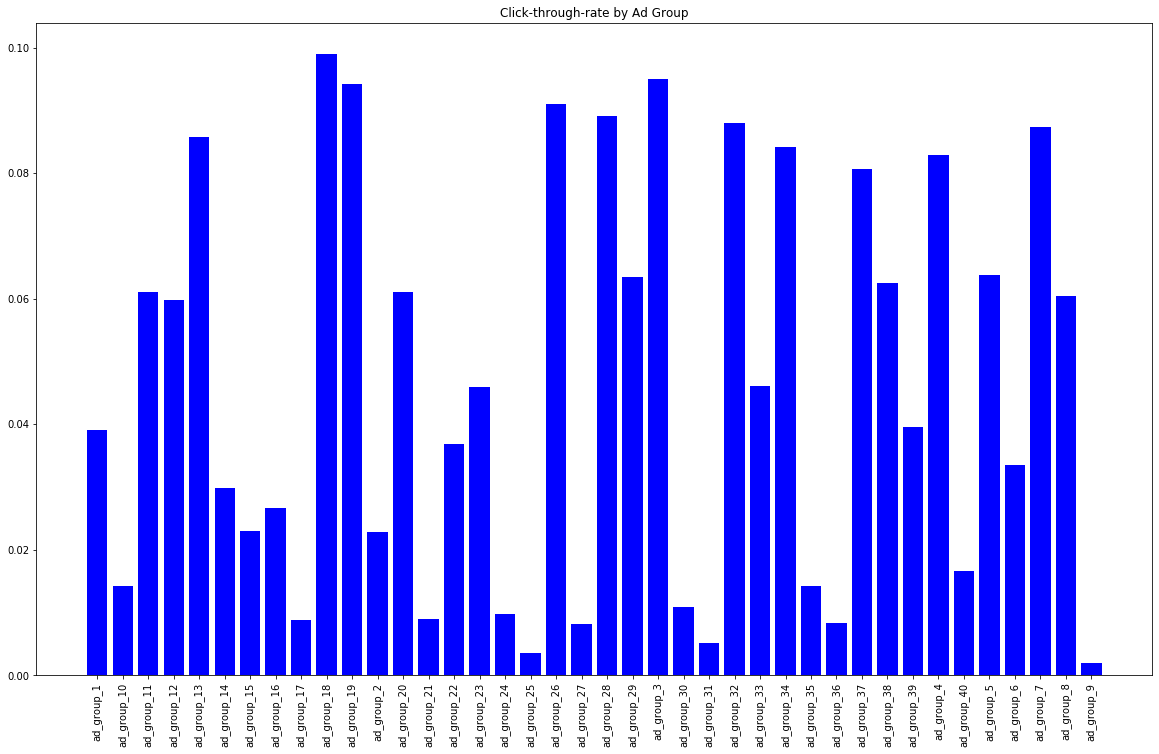

In [10]:
# group data by ad group
df_agg = pd.DataFrame({'shown': df['shown'], 'clicked' : df['clicked'], 'converted' : df['converted'], \
                       'ad': df['ad']}).groupby('ad').sum()

# calculate click-through-rate
ctr = pd.DataFrame({'shown_vs_clicked': df_agg['clicked']/df_agg['shown']})

# get top 5 profit ad groups
sort_ctr = ctr.sort_values(by='shown_vs_clicked')
best_ctr = sort_ctr[-5:]
print(best_ctr)

# plot grouped ad group profit
x = ctr.index
y = ctr['shown_vs_clicked'].tolist()
plt.figure(figsize=(20,12))
plt.xticks(rotation=90)
plt.bar(x, y, color="blue")
plt.title('Click-through-rate by Ad Group')
plt.show()

### 1.3 Positive recommendation - clicked vs. converted/purchased (i.e. conversion rate)
Pros: Measures how effectively the targeting of the ad was in terms of convincing a purchase. 

Cons: Introduces bias based on type of item. Customers are more inclined to impulsively purchase a cheap item than expensive on.

             clicked_vs_converted
ad                               
ad_group_34              0.087380
ad_group_16              0.088641
ad_group_12              0.091474
ad_group_13              0.094542
ad_group_2               0.100934


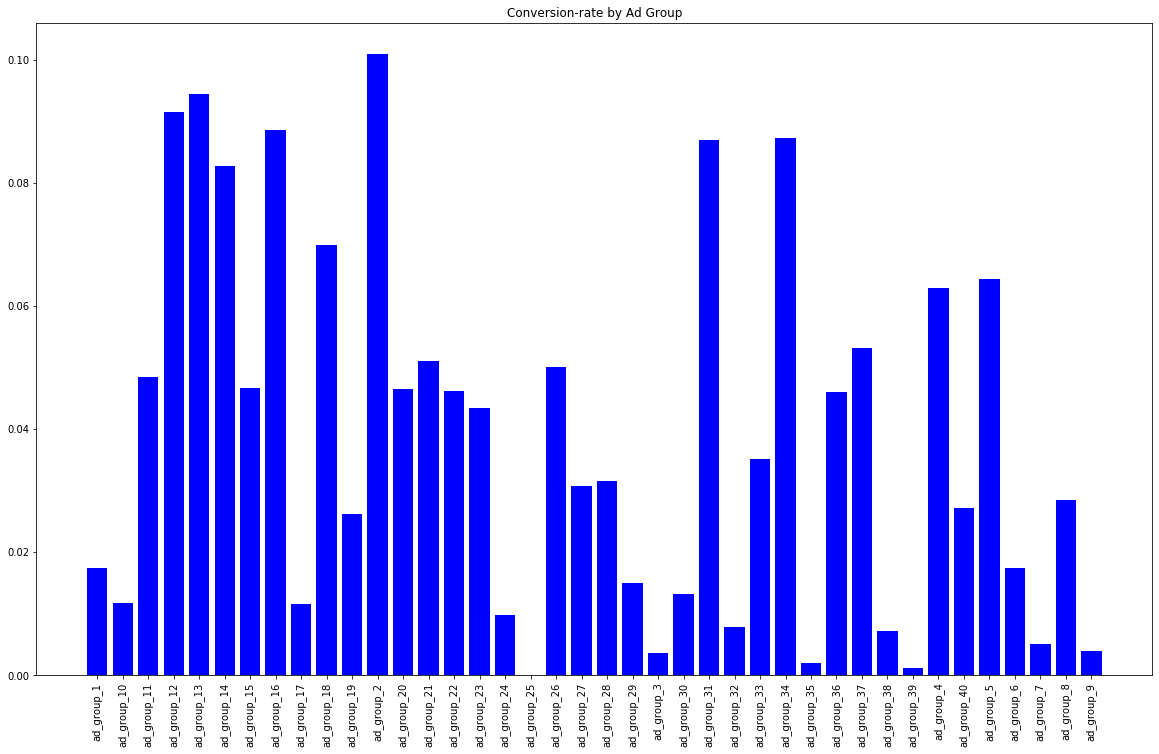

In [11]:
# calculate conversion-rate
cvr = pd.DataFrame({'clicked_vs_converted': df_agg['converted']/df_agg['clicked']})

# get top 5 profit ad groups
sort_cvr = cvr.sort_values(by='clicked_vs_converted')
best_cvr = sort_cvr[-5:]
print(best_cvr)

# plot grouped ad group profit
x = cvr.index
y = cvr['clicked_vs_converted'].tolist()
plt.figure(figsize=(20,12))
plt.xticks(rotation=90)
plt.bar(x, y, color="blue")
plt.title('Conversion-rate by Ad Group')
plt.show()

### 1.4 K-means Clustering -

Based on the three metrics for measuring ad performance, we will use K-means to cluster the ad-groups

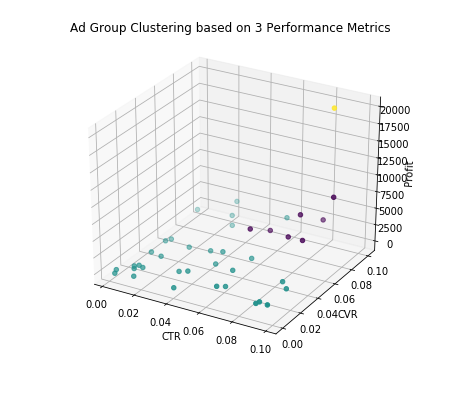

In [12]:
#join the three ad group metrics
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans

join = pd.DataFrame({'shown_vs_clicked':ctr['shown_vs_clicked'],'clicked_vs_converted':\
                     cvr['clicked_vs_converted'],'profit':df.groupby('ad')['total_revenue'].mean()})
ad_data = np.array(join)

np.random.seed(5)
    
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')
aa = KMeans(n_clusters=3).fit(ad_data)
labels = aa.labels_

ax.scatter(ad_data[:, 0], ad_data[:, 1], ad_data[:, 2],
            c=labels.astype(np.float), marker='o')

ax.set_xlabel('CTR')
ax.set_ylabel('CVR')
ax.set_zlabel('Profit')
ax.set_title('Ad Group Clustering based on 3 Performance Metrics')
ax.dist = 12
plt.show()

# 2. Predicting Ads Shown on December 15th, 2015

### 2.1 GAM - We will use a Generative Additive Model to predict the future performance of ads 

In [13]:
#build training data and test data
df_ad_group_1 = df[df['ad'] == 'ad_group_1']

df_ad_group_1['time_period'] = (df_ad_group_1['date'] - df_ad_group_1['date'][0]).dt.days
# X = df_ad_group_1[['time_period', 'clicked', 'converted', 'avg_cost_per_click', 'total_revenue']].values
X = df_ad_group_1[['time_period']].values

y = df_ad_group_1['shown'].values
X_test = [[(pd.to_datetime('2015-12-15') - df_ad_group_1['date'][0]).days]]
print(df_ad_group_1.shape)

(53, 8)


C:\Users\nisha\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


100% (240 of 240) |######################| Elapsed Time: 0:00:03 Time:  0:00:03
C:\Users\nisha\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      5.3776
Link Function:                     IdentityLink Log Likelihood:                                  -871.4906
Number of Samples:                           53 AIC:                                             1755.7363
                                                AICc:                                             1757.799
                                                GCV:                                          6740929.3012
                                                Scale:                                        5522163.4431
                                                Pseudo R-Squared:                                   0.3808
Feature Function                  Lam

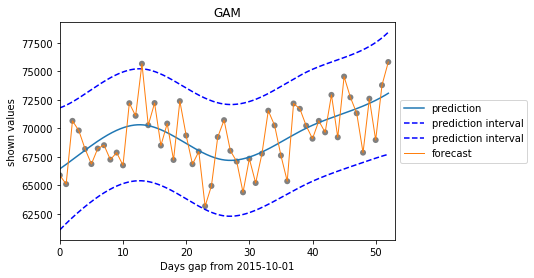

In [15]:
#Sample code : apply linear regression model for ad group 1
from pygam import LinearGAM

# plt.rcParams['figure.figsize'] = (400, 400)
gam = LinearGAM(n_splines=10).gridsearch(X, y, lam=np.logspace(-3,3, 6), n_splines=np.arange(40))
gam.summary()

XX = gam.generate_X_grid(term=0, n=1000)
plt.plot(XX, gam.predict(XX), label='prediction')
plt.plot(XX, gam.prediction_intervals(XX, width=.95), color='b', ls='--', label = 'prediction interval')

plt.xlim(0, 53)
plt.ylabel('shown values')
plt.xlabel('Days gap from 2015-10-01')
plt.title('GAM')

plt.scatter(X, y, facecolor='gray', edgecolors='none')
plt.plot(X, y, linewidth = 1, color = 'C1', label='forecast')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

print((pd.to_datetime('2015-12-15') - df_ad_group_1['date'][0]).days)

print(gam.predict([[75]]))
print(gam.lam)
print(gam.n_splines)

### Tuning parameters in GAM

In [16]:
list_ad_group = set(df['ad'].values)
len(list_ad_group)
tuning_result_each_group = {}
tuning_result_avg_gcv = {}
splines=[5, 7, 10, 20, 30, 40, 45]
lams = np.logspace(-3,3,7)
print(lams)
for ad_group in list_ad_group:
    df_ad_group_train = df[df['ad'] == ad_group]
    df_ad_group_train = df_ad_group_train.reset_index()
    df_ad_group_train['time_period'] = (df_ad_group_train['date'] - df_ad_group_train['date'][0]).dt.days
    X_train = df_ad_group_train[['time_period']].values
    y_train = df_ad_group_train['shown'].values
    #auto tuning
    gam = LinearGAM().gridsearch(X_train, y_train, lam=lams, n_splines=splines)
    predictions = gam.predict(X_train)
    print('==== Tuning for ad group %s - best generalized cross-validation %f ' % (ad_group, gam.statistics_['GCV']))
    tuning_result_each_group[ad_group] = (gam.lam[0][0], gam.n_splines[0], gam.statistics_['GCV'])
   

 16% (8 of 49) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

[1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 20% (10 of 49) |####                    | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_10 - best generalized cross-validation 22484832.253104 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 24% (12 of 49) |#####                   | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_16 - best generalized cross-validation 39348384.520120 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 20% (10 of 49) |####                    | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_4 - best generalized cross-validation 195330301.067301 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 16% (8 of 49) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_7 - best generalized cross-validation 6849026.510070 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 14% (7 of 49) |###                      | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_25 - best generalized cross-validation 591564057.317318 


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
 22% (11 of 49) |#####                   | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_21 - best generalized cross-validation 1483346.930502 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 24% (12 of 49) |#####                   | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_31 - best generalized cross-validation 21947800.148752 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 20% (10 of 49) |####                    | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_3 - best generalized cross-validation 28455608.034448 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 24% (12 of 49) |#####                   | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_40 - best generalized cross-validation 6510717.766979 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 20% (10 of 49) |####                    | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_18 - best generalized cross-validation 9519582.516673 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 24% (12 of 49) |#####                   | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_23 - best generalized cross-validation 51374673.820124 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 20% (10 of 49) |####                    | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_26 - best generalized cross-validation 6399621.667064 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 24% (12 of 49) |#####                   | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_33 - best generalized cross-validation 448096.234994 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 16% (8 of 49) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_17 - best generalized cross-validation 15980169.240035 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 16% (8 of 49) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_27 - best generalized cross-validation 6374581.937323 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 16% (8 of 49) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_11 - best generalized cross-validation 16865349.237726 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 24% (12 of 49) |#####                   | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_1 - best generalized cross-validation 6709968.990583 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 26% (13 of 49) |######                  | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_32 - best generalized cross-validation 2197216.251423 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 22% (11 of 49) |#####                   | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_19 - best generalized cross-validation 9082003.551043 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 14% (7 of 49) |###                      | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_2 - best generalized cross-validation 4308751.417538 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 24% (12 of 49) |#####                   | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_8 - best generalized cross-validation 4137908.404100 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 22% (11 of 49) |#####                   | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_30 - best generalized cross-validation 21658844.283381 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 16% (8 of 49) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_14 - best generalized cross-validation 80697.796371 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 18% (9 of 49) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_39 - best generalized cross-validation 884490.772889 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 24% (12 of 49) |#####                   | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_20 - best generalized cross-validation 312587844.764111 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 12% (6 of 49) |###                      | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_12 - best generalized cross-validation 17279516.792855 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 22% (11 of 49) |#####                   | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_24 - best generalized cross-validation 2323000.170217 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 14% (7 of 49) |###                      | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_38 - best generalized cross-validation 38013704.705388 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 22% (11 of 49) |#####                   | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_29 - best generalized cross-validation 586502.115801 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 14% (7 of 49) |###                      | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_28 - best generalized cross-validation 485999.716887 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 14% (7 of 49) |###                      | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_34 - best generalized cross-validation 1828918.960845 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 12% (6 of 49) |###                      | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_36 - best generalized cross-validation 5882384.979295 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 14% (7 of 49) |###                      | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_22 - best generalized cross-validation 930643.767130 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 14% (7 of 49) |###                      | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_37 - best generalized cross-validation 4986369.678275 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 20% (10 of 49) |####                    | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_6 - best generalized cross-validation 3400226.692864 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 14% (7 of 49) |###                      | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_9 - best generalized cross-validation 19565850.228744 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 22% (11 of 49) |#####                   | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_13 - best generalized cross-validation 1097183241.000266 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 16% (8 of 49) |####                     | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_35 - best generalized cross-validation 6151934.313712 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
 26% (13 of 49) |######                  | Elapsed Time: 0:00:00 ETA:   0:00:00

==== Tuning for ad group ad_group_5 - best generalized cross-validation 59303384.803230 


100% (49 of 49) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


==== Tuning for ad group ad_group_15 - best generalized cross-validation 422944.088508 


In [11]:
#build an Python script using GAM model, take input for ad group name and day in future -> output: prediction value of "shown"
# example: python ads_analysis_gam.py ad_group_30 2015-12-15
# create an independent Python script with a main function to check for arguments
# idea: use auto tuning like the above cell for one particular ad group, then call gam.predict - check sample code for adgroup 1 cell above

#visualization the tuning result for each ad group {ad group nname: lambda value, number of splines, GCV}
#NOTE: GAM uses GCV (generalized cross-validation) as the validationn metrics - this one is similar to error metrics 

### Tuning Results for each group

In [19]:
tuning_result_each_group #displays - {ad group nname: lambda value, number of splines, GCV}

{'ad_group_10': (0.1, 5, 22484832.25310391),
 'ad_group_16': (1000.0, 5, 39348384.52012015),
 'ad_group_4': (1.0, 5, 195330301.06730065),
 'ad_group_7': (0.1, 20, 6849026.510070026),
 'ad_group_25': (1000.0, 30, 591564057.3173177),
 'ad_group_21': (1.0, 40, 1483346.930501988),
 'ad_group_31': (0.01, 7, 21947800.148752153),
 'ad_group_3': (0.001, 10, 28455608.034448165),
 'ad_group_40': (0.001, 5, 6510717.766978522),
 'ad_group_18': (0.01, 5, 9519582.516673291),
 'ad_group_23': (0.1, 5, 51374673.82012397),
 'ad_group_26': (0.1, 7, 6399621.667063914),
 'ad_group_33': (0.001, 5, 448096.2349936182),
 'ad_group_17': (100.0, 30, 15980169.240034828),
 'ad_group_27': (1000.0, 5, 6374581.937322605),
 'ad_group_11': (1.0, 5, 16865349.237726215),
 'ad_group_1': (0.1, 7, 6709968.990582694),
 'ad_group_32': (0.001, 5, 2197216.251423246),
 'ad_group_19': (0.1, 5, 9082003.551043311),
 'ad_group_2': (1000.0, 5, 4308751.4175380645),
 'ad_group_8': (1.0, 10, 4137908.4040995366),
 'ad_group_30': (0.01, 2

### 2.2 ARMA

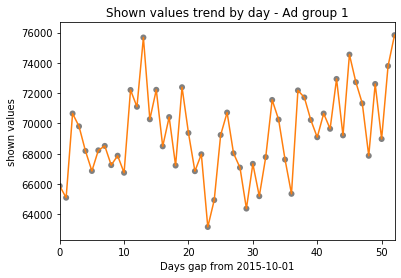

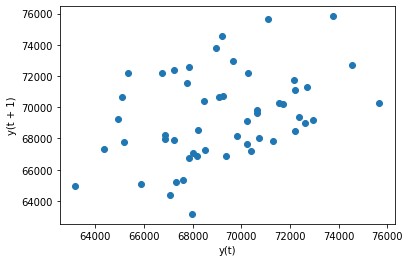

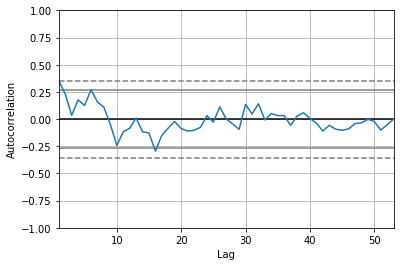

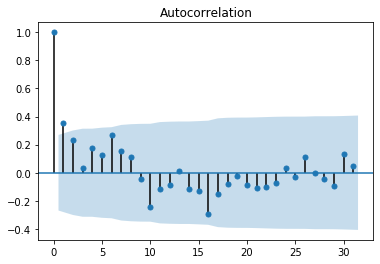

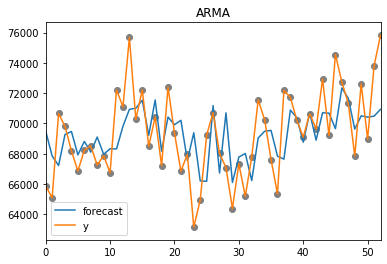

The required output (prediction of shown value on 2015-12-15) will be at the top of the forecast array
74887.32262699617
Array of out of sample forecasts
[74887.322627   70311.29774973 72034.84552208 70898.03797617
 70866.1911281  71053.83098743 70109.96534525 71048.3963178
 69677.79896111 70882.45755713 69517.13918761 70592.01651534
 69543.82066586 70244.10656215 69663.09760543 69910.04006527
 69792.87516223 69644.58889939 69878.2085605  69475.58424658
 69895.51307224 69403.48160885 69848.25063399 69408.06487414
 69757.4947095  69458.53706868 69651.08095999 69523.50371905
 69554.35521603 69578.39143608 69484.29143394 69609.18391152
 69447.43004621 69612.58619295 69441.02971538 69593.57717287
 69456.21687163 69561.68050267 69481.77894882 69527.22189426
 69507.47897606 69498.48492262 69526.20896132 69480.19911818
 69534.78041753 69473.34558403 69533.5430394  69475.94806654
 69525.25605496 69484.37169709 69513.69944433 69494.66429545
 69502.43749927 69503.59793415 69493.99263714 69509.23

In [21]:
import statsmodels.api as sm
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import ARMA
from datetime import datetime

#How to understand these plots: https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/
df_arma = df_ad_group_1[['shown', 'date']]
series = pd.Series(df_arma['shown'], index=df_arma.index)
series.plot(title='Shown values trend by day - Ad group 1', color = 'C1')
plt.ylabel('shown values')
plt.xlabel('Days gap from 2015-10-01')
plt.scatter(X, y, facecolor='gray', edgecolors='none')
plt.show()
#check for auto correlation
lag_plot(series)
plt.show()
autocorrelation_plot(series)
plt.show()
plot_acf(series.values, lags=31)
plt.show()

model = ARMA(series.values, order=(4,4))
model_fit = model.fit()
model_fit.plot_predict(plot_insample=True)
plt.scatter(X, y, color = 'gray')
plt.title('ARMA')
plt.show()
days_gap = (pd.to_datetime('2015-12-15') - df_arma['date'][0]).days
forecast = model_fit.forecast(steps=days_gap)

print('The required output (prediction of shown value on 2015-12-15) will be at the top of the forecast array')
print(forecast[0][0])

print('Array of out of sample forecasts')
print(forecast[0])
# print('Array of out of standard error of forecasts')
# print(forecast[1])
# print('2d array of the confidence interval for the forecast')
# print(forecast[2])



In [22]:
import statsmodels.tsa.api as smt
import statsmodels.stats as sms
import scipy.stats as scs
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

In [24]:
#Tuning Params
from statsmodels.stats.stattools import jarque_bera

rng = 6
alpha_list = [0.1, 0.5, 1, 2, 3]
beta_list = [0.1, 0.5, 1, 2, 3]
best_aic = np.inf 
best_order = None
best_mdl = None
max_lag = 30
tuning_result = {}
for ad_group in list_ad_group:
    df_ad_group_train = df[df['ad'] == ad_group]
    df_ad_group_train = df_ad_group_train.reset_index()
    df_arma_train = df_ad_group_train[['shown', 'date']]
    series_train = pd.Series(df_arma_train['shown'], index=df_arma_train.index)
    for alpha in alpha_list:
        for beta in beta_list:
            try:
                tmp_mdl = ARMA(series_train.values, order=(alpha, beta)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (alpha, beta)
                    best_mdl = tmp_mdl
            except: continue
    score, pvalue, a, b = jarque_bera(best_mdl.resid)

    if pvalue < 0.10:
        print('The residuals may not be normally distributed.')
    else:
        print('The residuals seem normally distributed.')
    tuning_result[ad_group] = (best_aic, best_order)
    print('Ad_group: {} aic: {:6.2f} | best order: {}'.format(ad_group, best_aic, best_order))
#     print('Plot for ad group ', ad_group)
#     _ = tsplot(best_mdl.resid, lags=max_lag)

The residuals may not be normally distributed.
Ad_group: ad_group_10 aic: 1053.79 | best order: (1, 3)


C:\Users\nisha\Anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:221: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
C:\Users\nisha\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\nisha\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\nisha\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\nisha\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The residuals may not be normally distributed.
Ad_group: ad_group_16 aic: 1053.79 | best order: (1, 3)
The residuals may not be normally distributed.
Ad_group: ad_group_4 aic: 1053.79 | best order: (1, 3)
The residuals may not be normally distributed.
Ad_group: ad_group_7 aic: 1053.79 | best order: (1, 3)
The residuals may not be normally distributed.
Ad_group: ad_group_25 aic: 1053.79 | best order: (1, 3)
The residuals may not be normally distributed.
Ad_group: ad_group_21 aic: 912.85 | best order: (1, 2)
The residuals may not be normally distributed.
Ad_group: ad_group_31 aic: 912.85 | best order: (1, 2)
The residuals may not be normally distributed.
Ad_group: ad_group_3 aic: 912.85 | best order: (1, 2)
The residuals may not be normally distributed.
Ad_group: ad_group_40 aic: 912.85 | best order: (1, 2)
The residuals may not be normally distributed.
Ad_group: ad_group_18 aic: 912.85 | best order: (1, 2)


C:\Users\nisha\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


The residuals may not be normally distributed.
Ad_group: ad_group_23 aic: 912.85 | best order: (1, 2)
The residuals may not be normally distributed.
Ad_group: ad_group_26 aic: 912.85 | best order: (1, 2)
The residuals may not be normally distributed.
Ad_group: ad_group_33 aic: 912.85 | best order: (1, 2)
The residuals may not be normally distributed.
Ad_group: ad_group_17 aic: 912.85 | best order: (1, 2)
The residuals may not be normally distributed.
Ad_group: ad_group_27 aic: 912.85 | best order: (1, 2)


C:\Users\nisha\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\nisha\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\nisha\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\nisha\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The residuals may not be normally distributed.
Ad_group: ad_group_11 aic: 912.85 | best order: (1, 2)
The residuals may not be normally distributed.
Ad_group: ad_group_1 aic: 912.85 | best order: (1, 2)


C:\Users\nisha\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The residuals may not be normally distributed.
Ad_group: ad_group_32 aic: 912.85 | best order: (1, 2)
The residuals may not be normally distributed.
Ad_group: ad_group_19 aic: 912.85 | best order: (1, 2)


C:\Users\nisha\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


The residuals may not be normally distributed.
Ad_group: ad_group_2 aic: 912.85 | best order: (1, 2)
The residuals may not be normally distributed.
Ad_group: ad_group_8 aic: 912.85 | best order: (1, 2)
The residuals may not be normally distributed.
Ad_group: ad_group_30 aic: 912.85 | best order: (1, 2)
The residuals may not be normally distributed.
Ad_group: ad_group_14 aic: 912.85 | best order: (1, 2)
The residuals may not be normally distributed.
Ad_group: ad_group_39 aic: 912.85 | best order: (1, 2)
The residuals may not be normally distributed.
Ad_group: ad_group_20 aic: 912.85 | best order: (1, 2)
The residuals may not be normally distributed.
Ad_group: ad_group_12 aic: 912.85 | best order: (1, 2)
The residuals may not be normally distributed.
Ad_group: ad_group_24 aic: 912.85 | best order: (1, 2)


C:\Users\nisha\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The residuals may not be normally distributed.
Ad_group: ad_group_38 aic: 912.85 | best order: (1, 2)


C:\Users\nisha\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\nisha\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\nisha\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The residuals may not be normally distributed.
Ad_group: ad_group_29 aic: 868.67 | best order: (2, 1)
The residuals may not be normally distributed.
Ad_group: ad_group_28 aic: 868.67 | best order: (2, 1)
The residuals may not be normally distributed.
Ad_group: ad_group_34 aic: 868.67 | best order: (2, 1)
The residuals may not be normally distributed.
Ad_group: ad_group_36 aic: 868.67 | best order: (2, 1)
The residuals may not be normally distributed.
Ad_group: ad_group_22 aic: 868.67 | best order: (2, 1)
The residuals may not be normally distributed.
Ad_group: ad_group_37 aic: 868.67 | best order: (2, 1)
The residuals may not be normally distributed.
Ad_group: ad_group_6 aic: 868.67 | best order: (2, 1)
The residuals may not be normally distributed.
Ad_group: ad_group_9 aic: 868.67 | best order: (2, 1)


C:\Users\nisha\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\nisha\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The residuals may not be normally distributed.
Ad_group: ad_group_13 aic: 868.67 | best order: (2, 1)


C:\Users\nisha\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\nisha\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The residuals may not be normally distributed.
Ad_group: ad_group_35 aic: 868.67 | best order: (2, 1)
The residuals may not be normally distributed.
Ad_group: ad_group_5 aic: 868.67 | best order: (2, 1)


C:\Users\nisha\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\nisha\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The residuals may not be normally distributed.
Ad_group: ad_group_15 aic: 836.37 | best order: (2, 2)


C:\Users\nisha\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
#TODO: Preethi -> build an Python script using ARMA model, take input for ad group name and day in future -> output: prediction value of "shown"
# example: python ads_analysis_arma.py ad_group_30 2015-12-15
# create an independent Python script with a main function to check for arguments
# idea: tuning and look for best model like the above cell for one particular ad group, then call forecast function - check sample code for adgroup 1 cell above

In [25]:
tuning_result
#TODO: Preethi - visualize the tuning result for ad groups - adgroup id : AIC, (alpha, beta)
#NOTE: ARMA uses AIC as the validation metric https://en.wikipedia.org/wiki/Akaike_information_criterion

{'ad_group_10': (1053.7862244616867, (1, 3)),
 'ad_group_16': (1053.7862244616867, (1, 3)),
 'ad_group_4': (1053.7862244616867, (1, 3)),
 'ad_group_7': (1053.7862244616867, (1, 3)),
 'ad_group_25': (1053.7862244616867, (1, 3)),
 'ad_group_21': (912.8505993670444, (1, 2)),
 'ad_group_31': (912.8505993670444, (1, 2)),
 'ad_group_3': (912.8505993670444, (1, 2)),
 'ad_group_40': (912.8505993670444, (1, 2)),
 'ad_group_18': (912.8505993670444, (1, 2)),
 'ad_group_23': (912.8505993670444, (1, 2)),
 'ad_group_26': (912.8505993670444, (1, 2)),
 'ad_group_33': (912.8505993670444, (1, 2)),
 'ad_group_17': (912.8505993670444, (1, 2)),
 'ad_group_27': (912.8505993670444, (1, 2)),
 'ad_group_11': (912.8505993670444, (1, 2)),
 'ad_group_1': (912.8505993670444, (1, 2)),
 'ad_group_32': (912.8505993670444, (1, 2)),
 'ad_group_19': (912.8505993670444, (1, 2)),
 'ad_group_2': (912.8505993670444, (1, 2)),
 'ad_group_8': (912.8505993670444, (1, 2)),
 'ad_group_30': (912.8505993670444, (1, 2)),
 'ad_group_

### 2.3 Simple method: linear regression 
Library: scikit-learn

array([72513.15803903])

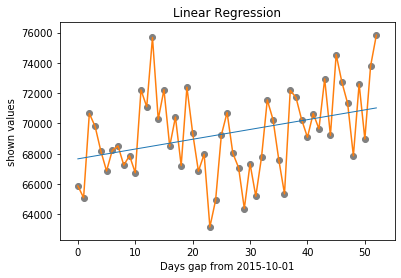

In [26]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X, y)
plt.plot(X, y, color = 'C1')
plt.title('Linear Regression')
plt.scatter(X, y, color = 'gray')
plt.ylabel('shown values')
plt.xlabel('Days gap from 2015-10-01')
plt.plot(X, reg.predict(X), linewidth = 1)
reg.predict(X_test)

# 3. Cluster ads into 3 groups: 

The ones whose avg_cost_per_click is going up, the ones whose avg_cost_per_click is flat and the ones whose avg_cost_per_click is going down

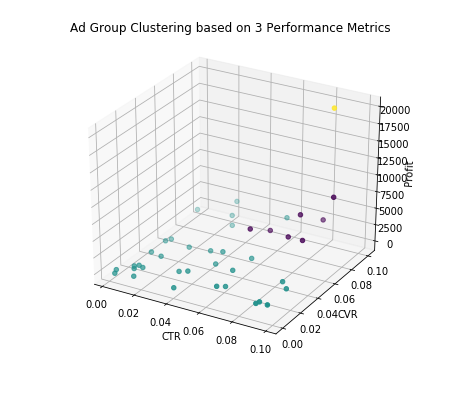

In [27]:
import numpy as np
import pandas as pd
from scipy.stats import gmean
import matplotlib.pyplot as plt


ads_file = 'data/ad_table.csv'
df = pd.read_csv(ads_file, header=0, sep=',')

df_agg = pd.DataFrame({'shown': df['shown'], 'clicked' : df['clicked'], 'converted' : df['converted'], \
                       'ad': df['ad']}).groupby('ad').sum()

ctr = pd.DataFrame({'shown_vs_clicked': df_agg['clicked']/df_agg['shown']})
cvr = pd.DataFrame({'clicked_vs_converted': df_agg['converted']/df_agg['clicked']})

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans

join = pd.DataFrame({'shown_vs_clicked':ctr['shown_vs_clicked'],'clicked_vs_converted':\
                     cvr['clicked_vs_converted'],'profit':df.groupby('ad')['total_revenue'].mean()})
ad_data = np.array(join)

np.random.seed(5)
    
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111, projection='3d')
aa = KMeans(n_clusters=3).fit(ad_data)
labels = aa.labels_

ax.scatter(ad_data[:, 0], ad_data[:, 1], ad_data[:, 2],
            c=labels.astype(np.float), marker='o')

ax.set_xlabel('CTR')
ax.set_ylabel('CVR')
ax.set_zlabel('Profit')
ax.set_title('Ad Group Clustering based on 3 Performance Metrics')
ax.dist = 12
plt.show()